In [5]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation
import magpylib as magpy
import os
import pandas as pd
from datetime import timedelta
import sys
from datetime import datetime

M0 = 1480 #mT
shape = [5*25.4/8, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])

In [6]:
def getField_cylinder(x, positions, M0, shape):
    B=magpy.getB(
        sources="Cylinder",
        position=x[:3],
        orientation=Rotation.align_vectors(x[3:], np.array([0, 0, 1]))[0],
        observers=positions,
        dimension=shape,
        polarization=(0, 0, M0),
    )
    return B

def cost_cylinder(x, B, positions, M0, shape):
    diff = getField_cylinder(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)

def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, options={'maxiter':10000}, *args
    ) 
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res.x 

# Function to extract the timestamp part from the file path
def extract_timestamp(file_path):
    # Extract the filename from the file path (without the extension)
    filename = os.path.basename(file_path).replace('.npz', '')
    
    # Split the filename into date, time, and millisecond parts
    date_part = filename.split('-')[0]  # Extracting the 'YYYYMMDD' part
    time_part = filename.split('-')[1]  # Extracting the 'HHMMSS' part
    millisecond_part = filename.split('-')[2]  # Extracting the millisecond part
    
    # Combine date, time, and milliseconds into a full timestamp string
    full_datetime_str = f"{date_part} {time_part}.{millisecond_part}"
    
    # Create a datetime object
    full_datetime = datetime.strptime(full_datetime_str, "%Y%m%d %H%M%S.%f")
    
    return full_datetime

def importdata(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    #print(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]
    B = [np.array(pos)]
    timestamps = []

    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            display(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        mags = np.mean(mags, axis=0)
        
        B = np.append(B, [mags], axis=0)
        timestamps.append(extract_timestamp(file_list[x]))  
    B = np.delete(B, 0, axis=0)

    return B, timestamps, pos

def fitting(B, pos):
    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]

    for x in range(len(B)):
        mags = B[x]
        #print(mags)
        x_res = minimize(x0, mags, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        #print(locpred)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)

    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    

    return locpred, anglepred

def locplots(locpred, timestamps):
    measuredbx = go.Scatter(x=timestamps, y=locpred[:,0], mode='markers')
    layoutbx = go.Layout(title='x over time (mm)')
    figbx = go.Figure(data=[measuredbx], layout=layoutbx)
    figbx.update_yaxes(scaleanchor='y')
    figbx.update_layout(
        xaxis_title="Time",
        yaxis_title="x [mm]"
    )
    figbx.show()

    measuredby = go.Scatter(x=timestamps, y=locpred[:,1], mode='markers')
    layoutby = go.Layout(title='y over time (mm)')
    figby = go.Figure(data=[measuredby], layout=layoutby)
    figby.update_yaxes(scaleanchor='y')
    figby.update_layout(
        xaxis_title="Time",
        yaxis_title="y [mm]"
    )
    figby.show()

    measuredbz = go.Scatter(x=timestamps, y=locpred[:,2], mode='markers')
    layoutbz = go.Layout(title='z over time (mm)')
    figbz = go.Figure(data=[measuredbz], layout=layoutbz)
    figbz.update_yaxes(scaleanchor='y')
    figbz.update_layout(
        xaxis_title="Time",
        yaxis_title="z [mm]"
    )
    figbz.show()

def sensorplots(B, timestamps, sensor):
    mag = [np.array([0, 0, 0])]
    for x in range(len(B)):
        mag = np.append(mag, [B[x][sensor]], axis=0)
    mag = np.delete(mag, 0, axis=0)

    measuredbx = go.Scatter(x=timestamps, y=mag[:,0], mode='markers')
    layoutbx = go.Layout(title='b_x over time, sensor ' + str(sensor))
    figbx = go.Figure(data=[measuredbx], layout=layoutbx)
    figbx.update_yaxes(scaleanchor='y')
    figbx.update_layout(
        xaxis_title="Time",
        yaxis_title="b_x [mT]"
    )
    figbx.show()

    measuredby = go.Scatter(x=timestamps, y=mag[:,1], mode='markers')
    layoutby = go.Layout(title='b_y over time sensor ' + str(sensor))
    figby = go.Figure(data=[measuredby], layout=layoutby)
    figby.update_yaxes(scaleanchor='y')
    figby.update_layout(
        xaxis_title="Time",
        yaxis_title="b_y [mT]"
    )
    figby.show()

    measuredbz = go.Scatter(x=timestamps, y=mag[:,2], mode='markers')
    layoutbz = go.Layout(title='b_z over time sensor ' + str(sensor))
    figbz = go.Figure(data=[measuredbz], layout=layoutbz)
    figbz.update_yaxes(scaleanchor='y')
    figbz.update_layout(
        xaxis_title="Time",
        yaxis_title="b_z [mT]"
    )
    figbz.show()


In [7]:
def importdata_corr(folder, threshold=5):
    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    data = np.load(file_list[0])
    pos = data['pos'][0]
    B = [np.array(pos)]
    timestamps = []

    # Initialize previous value to the first reading
    previous_mags = np.mean(data['mags'], axis=0)

    for x in range(len(file_list)):
        try:
            data = np.load(file_list[x])
        except:
            print(f"Could not load file: {file_list[x]}")
            continue  # Skip this file if it can't be loaded

        mags = data['mags']
        pos = data['pos'][0]
        mags = np.mean(mags, axis=0)

        # Calculate relative difference and check for a discontinuity
        relative_diff = np.abs((mags - previous_mags) / (previous_mags + 1e-8))  # Avoid division by zero
        if np.any(relative_diff > threshold) and np.any(np.sign(previous_mags) != np.sign(mags)):
            mags = -mags  # Flip the sign to maintain continuity if there's an abrupt sign change

        B = np.append(B, [mags], axis=0)
        timestamps.append(extract_timestamp(file_list[x]))

        previous_mags = mags  # Update previous value

    B = np.delete(B, 0, axis=0)

    return B, timestamps, pos

In [8]:
folder = os.path.join('..', './MLX01222025_DA2N52_z45')
B, timestamps, pos = importdata(folder)

In [9]:
sensorplots(B, timestamps, 8)

In [10]:
def moving_average_3d(arr, window_size=3):
    # Ensure input is 3D
    if arr.ndim != 3:
        raise ValueError("Input array must be 3D.")
    
    # Initialize smoothed array with zeros
    smoothed_arr = np.zeros_like(arr)
    
    # Apply moving average along the first dimension for each column in 2D slices
    for i in range(arr.shape[1]):
        for j in range(arr.shape[2]):
            kernel = np.ones(window_size) / window_size
            smoothed_slice = np.convolve(arr[:, i, j], kernel, mode='same')
            smoothed_arr[:, i, j] = smoothed_slice
            
    return smoothed_arr

def average_along_first_dim(arr, window_size=3):
    # Ensure input is 3D
    if arr.ndim != 3:
        raise ValueError("Input array must be 3D.")
    
    # Calculate the shape of the output array based on window size
    num_windows = arr.shape[0] // window_size
    averaged_arr = np.zeros((num_windows, arr.shape[1], arr.shape[2]))
    
    # Loop through and calculate the mean for each window
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        averaged_arr[i] = np.mean(arr[start_idx:end_idx], axis=0)
        
    return averaged_arr

test = average_along_first_dim(B, window_size=5)
print(len(test))

252


In [11]:
# timestamps
# # Define the incorrect and correct times
# incorrect_time = pd.to_datetime("6:00:00").time()  # Incorrect time (6:01)
# correct_time = pd.to_datetime("12:08:00").time()   # Correct time (2:24)

# # Calculate the time difference
# time_difference = timedelta(hours=correct_time.hour, minutes=correct_time.minute, seconds=correct_time.second) - \
#                   timedelta(hours=incorrect_time.hour, minutes=incorrect_time.minute, seconds=incorrect_time.second)

# # Apply the time difference to correct the list of incorrect timestamps
# corrected_timestamps = [t + time_difference for t in timestamps]
# corrected_timestamps

# ave_timestamps = corrected_timestamps[4::5]
# print(len(ave_timestamps))

In [12]:
locpred, anglepred = fitting(B, pos)

c:\Users\Brandon Nguyen\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_slsqp_py.py:434: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



In [13]:
timestamps
display(locpred)
locpred[:,0]

array([[  1.02564285, -22.84173404,  34.69016899],
       [  1.01937142, -22.78778766,  34.73263905],
       [  1.0794952 , -22.81436855,  34.71580171],
       ...,
       [  1.10220862, -22.70080074,  34.8777472 ],
       [  1.0730019 , -22.59147466,  34.97681334],
       [  1.09228519, -22.63636933,  34.93513992]])

array([1.02564285, 1.01937142, 1.0794952 , ..., 1.10220862, 1.0730019 ,
       1.09228519])

[0.         0.0689438  0.06561998 ... 0.2467997  0.38345484 0.32653731]


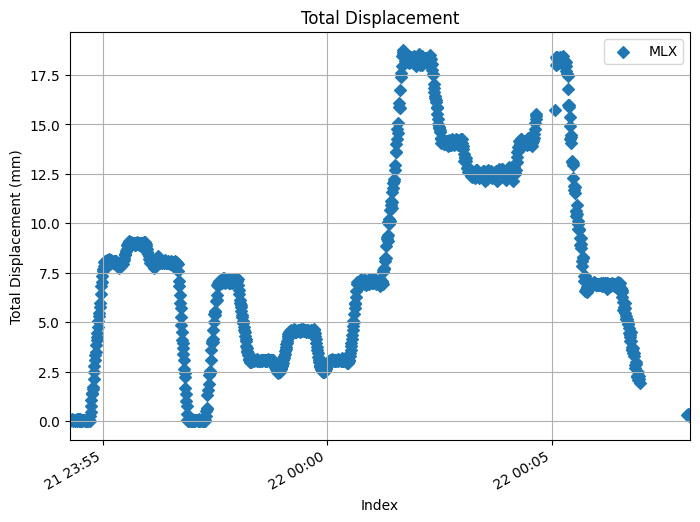

In [14]:
rel_loc_predx = [x - locpred[0,0] for x in locpred[:,0]]
rel_loc_predy = [x - locpred[0,1] for x in locpred[:,1]]
rel_loc_predz = [x - locpred[0,2] for x in locpred[:,2]]


dispx = np.array(rel_loc_predx)
dispy = np.array(rel_loc_predy)
dispz = np.array(rel_loc_predz)
disp = np.sqrt(dispx**2+dispy**2+dispz**2)

print(disp)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(timestamps, disp, label='MLX', marker="D")
# Set x-axis labels to show only the time
# Format the x-axis to show date and time properly
plt.gcf().autofmt_xdate()  # Auto-format the dates on the x-axis
#plt.ylim([-1, 6])
plt.xlim(timestamps[0], timestamps[-1])
plt.xlabel('Index')
plt.ylabel('Total Displacement (mm)')
plt.title('Total Displacement')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
locplots(locpred, timestamps)